# EDA & Provisioning - RAPP 

## 1. Context

Rotterdam Accommodation Price Predictor (RAPP) is a machine learning project aimed at predicting the accommodation price in Rotterdam for seekers, especially the Vietnamese community in the city. Features to consider will be taken from attributes of the accommodations (e.g. distant to city center) and infrastructure facts (e.g. surface area). Unanchored data for this project has been scraped from [Pararius](https://www.pararius.com/apartments/rotterdam/page-1). The process could be found in a separate notebook - "Data Scraper - RAPP", and the reasoning for choosing the site as source can be found in the proposal. This notebook contains the EDA and data provisioning for the project.

## 2. EDA 

To explore the scraped data, it is necessary to import some needed libraries and the dataset from the local storage. The dataset will be called 'rtd_housing'.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
%matplotlib inline

In [3]:
rtd_housing = pd.read_csv(r'C:\Users\pnanp\Desktop\Housing_GC\housing.csv', index_col = 0)

Some rows of rtd_housing and its shape will be viewed to explore what the data currently looks like.

In [4]:
rtd_housing.head()

,house_price,rental_agency,postcode,rooms,surface,type,label
0,3150,Dop & Dop Consultancy,3072ES,5,145,House,Maashavenkade
1,2500,Fransen Vastgoed,3033AB,2,65,Apartment,Walenburgerweg
2,2300,Loftly,3014GJ,2,55,Apartment,Nieuwe Binnenweg
3,2300,Stad en Land Makelaars,3071NR,4,101,Apartment,Maaskade 159 D
4,2500,Stad en Land Makelaars,3065PG,3,110,Apartment,Huub van den Brulestraat 103


In [5]:
rtd_housing.shape

(1438, 7)

There are currently 7 columns and 1438 rows in rtd_housing. Descriptions of the current features are as follow:
* house_price: EUR price of accommodation
* rental_agency: the agency responsible for the accommodation
* postcode: postcode of accommodation
* rooms: number of rooms
* surface: rounded surface area (m^2)
* type: apartment/house/room
* label: address in written format

It is noteworthy that the website has a highlighting feature which repeats certain ads. Beside this, some could also be repeated due to them not being removed before an update in available date. This means that duplications need to be checked for; the condition for a row to be branded a duplicate in this context is if all values match those of another row.

In [6]:
print("Number of duplicated ads: {}".format(len(rtd_housing[rtd_housing.duplicated()])))
print("After removal, there will be {} rows left".format(len(rtd_housing) - len(rtd_housing[rtd_housing.duplicated()])))

Number of duplicated ads: 159
After removal, there will be 1279 rows left


From the duplication checking above, it seems that the removal of duplications will still leave 1279 rows. With this amount of data, further processing and modelling could still proceed. Hence, the code below will drop the duplicates.

In [7]:
rtd_housing = rtd_housing.drop_duplicates(ignore_index = True)

Next, number of null values in each column should be checked. Since the scaper has gathered all mandatory 'tags' from the Pararius website, the value judgement is that there should be no null values. However, it will still be checked for certainty.

In [8]:
rtd_housing.isna().sum()

house_price      0
rental_agency    0
postcode         0
rooms            0
surface          0
type             0
label            0
dtype: int64

The result confirms that there is no null value within this dataset. Which brings the next question: are all columns in the right datatype? Information on rtd_housing will be displayed to confirm this.

In [8]:
rtd_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   house_price    1279 non-null   int64 
 1   rental_agency  1279 non-null   object
 2   postcode       1279 non-null   object
 3   rooms          1279 non-null   int64 
 4   surface        1279 non-null   int64 
 5   type           1279 non-null   object
 6   label          1279 non-null   object
dtypes: int64(3), object(4)
memory usage: 70.1+ KB


The datatypes are suitable considering the detail of the features. To further understand the components of the data, the distribution of house_price with respect to other features such as surface area and number of rooms will be visualized using 'Seaborn'.

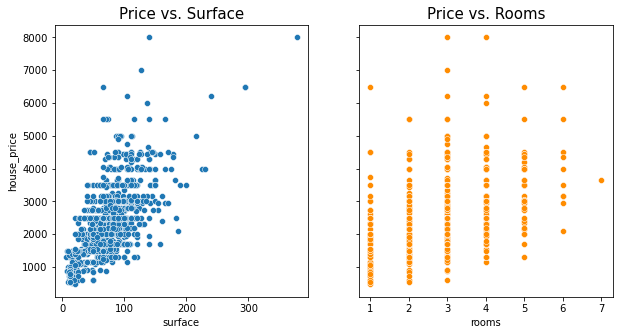

In [9]:
fig, ax = plt.subplots(1,2, sharey = True, figsize = (10, 5))

sns.scatterplot(ax = ax[0], data = rtd_housing, x = 'surface', y = 'house_price')
sns.scatterplot(ax = ax[1], data = rtd_housing, x = 'rooms', y = 'house_price', color = 'darkorange')

ax[0].set_title('Price vs. Surface', size = 15)
ax[1].set_title('Price vs. Rooms', size = 15)

plt.show()

Looking at the first illustration, most of the accommodations in this dataset have area less than or equal to 200m^2. It is observable that the rental price generally increases when surface area of accommodation increases. However, this does not mean that a larger surface will always cost more per month than a smaller one. For example, there are still accommodations of 100m^2 that have higher price than those of 200m^2. The same could be observed for price increase with regards to number of rooms. Some one-room accommodations can cost more than others with 2 or 3 rooms. These insights suggest that there is more to rental price in Rotterdam than just area and number of rooms, and more features are needed. 

Because the inspiration for RAPP is to help Vietnamese students in Rotterdam find 'comfortable' housing (taking proximity to commutation/leisure hub into account - as defined in the proposal), distance to [Blaak](https://nominatim.openstreetmap.org/ui/details.html?osmtype=W&osmid=7523371&class=highway) will be a good start for anchoring. This is because Blaak is a notable street in Rotterdam center and the selected point (on Blaak) is next to an area that has many commutation and leisure facilities. More information will be provided further below.  

To do this, it is necessary to first get the approximate coordinates of accommodations based on postcodes. After which, the distance can be calculated between the coordinates and that of Blaak's point. By utilizing the geolocation service [Nominatim](https://nominatim.openstreetmap.org/ui/search.html) via geopy for geocoding, the tasks can be carried out.

In [10]:
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
from geopy import distance
import geopy

The code below will make a copy of the rtd_housing dataset for manipulation. After which, it will derive the approximate  locations based on postcodes, find the coordinate points of those locations, and split the components into longitude - lattitude - altitude. This split will make it easier for viewing and future calculation/plotting if needed. There will also be a delay between requests to prevent overloading of Nominatim's service.  

In [11]:
df = rtd_housing.copy()

# Nominatim requires user_agent. This can be found online for each user by searching.
geolocator = Nominatim(user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36')

# setup delay to prevent overloading
geocode = RateLimiter(geolocator.geocode, min_delay_seconds = 1)

df['location'] = df['postcode'].apply(geocode)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)

In [12]:
df.head()

,house_price,rental_agency,postcode,rooms,surface,type,label,location,point,latitude,longitude,altitude
0,3150,Dop & Dop Consultancy,3072ES,5,145,House,Maashavenkade,"(Rotterdam, Zuid-Holland, Nederland, 3072ES, N...","(51.8985075911765, 4.481167817647057, 0.0)",51.898508,4.481168,0.0
1,2500,Fransen Vastgoed,3033AB,2,65,Apartment,Walenburgerweg,"(Noord, Rotterdam, Zuid-Holland, Nederland, 30...","(51.93019030833333, 4.468911525, 0.0)",51.930190,4.468912,0.0
2,2300,Loftly,3014GJ,2,55,Apartment,Nieuwe Binnenweg,"(Centrum, Rotterdam, Zuid-Holland, Nederland, ...","(51.91556355000001, 4.466434615000001, 0.0)",51.915564,4.466435,0.0
3,2300,Stad en Land Makelaars,3071NR,4,101,Apartment,Maaskade 159 D,"(Rotterdam, Zuid-Holland, Nederland, 3071NR, N...","(51.91110445625, 4.489544531250001, 0.0)",51.911104,4.489545,0.0
4,2500,Stad en Land Makelaars,3065PG,3,110,Apartment,Huub van den Brulestraat 103,"(Rotterdam, Zuid-Holland, Nederland, 3065PG, N...","(51.92671556060607, 4.5639173825757595, 0.0)",51.926716,4.563917,0.0


Taking the first row for double-checking with the Nominatim web interface, the following result can be derived when using coordinate as input:

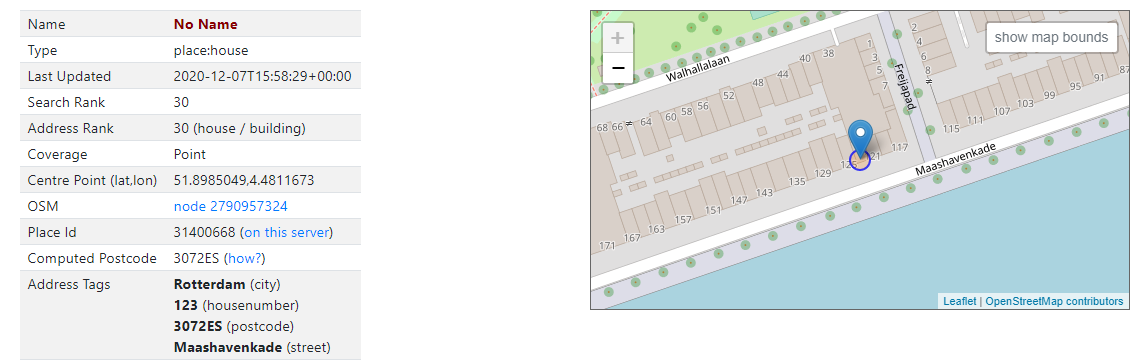

As observable from the result above, the pinpoint is on the same 'Maashavenkade' street as the data row. Hence, the approximate coordinates have successfully been added. The next step is to find the relative distance between the accommodations and Blaak's point. Although Blaak is a notable street in Rotterdam center, only one point can be selected. This point (shown in the image below) is at a place similar to city square, with many commutation and leisure facilities; hence, it has been selected. 

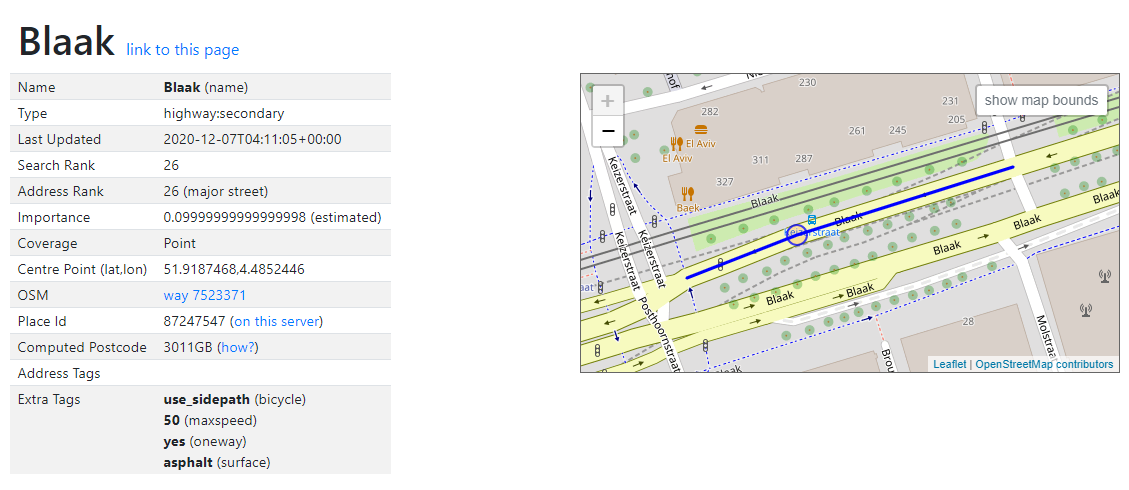

The latitude is 51.9187468, while the longitude is 4.4852446. After making a copy of df called df2, the flat distance to the selected point (aka city square) for all points in the 'point' column can be found using geopy. The results should be appended to a list, which will then become the 'distance' column.

In [13]:
df2 = df.copy()
distance = []
rtd_center = (51.9187468, 4.4852446)
for point in df2['point']:
    dist = geopy.distance.distance(point, rtd_center)
    distance.append(dist)
    
df2.insert(8, 'distance', distance, True) 

In [14]:
df2.distance

0        2.269337137058755 km
1       1.6981526206676945 km
2       1.3418057749323526 km
3        0.900334385520483 km
4        5.484532278206884 km
                ...          
1274     4.318310279169002 km
1275    2.2226442376330557 km
1276    0.5781025095248533 km
1277    4.6764152466246856 km
1278    1.6640155086434987 km
Name: distance, Length: 1279, dtype: object

Now that the distance has been added, a final wrangling step should be performed on it. The current datatype needs to be changed to float and 'km' needs to be removed as below.

In [15]:
df2['distance'] = df2['distance'].astype(str).str[:-3].astype(float)

In [16]:
df2.distance

0       2.269337
1       1.698153
2       1.341806
3       0.900334
4       5.484532
          ...   
1274    4.318310
1275    2.222644
1276    0.578103
1277    4.676415
1278    1.664016
Name: distance, Length: 1279, dtype: float64

The final wrangling of the distance has been completed. Before further anchoring, the distribution of accommodations and throughout Rotterdam will be looked at. This geo-plotting will utilize the library folium and its heatmap, marker, and map. 

In [41]:
# making a map centered around the chosen point on Blaak.
rtd_map = folium.Map(location=[51.9187468, 4.4852446], zoom_start = 13)

# adding heatmap for distribution of accommodations (using coordinates)
heat_data = [[row['latitude'],row['longitude'] ] for index, row in df2.iterrows()]
plugins.HeatMap(heat_data, radius = 10).add_to(rtd_map)

# mark the 'city square' point, showing where "centrum" is
folium.Marker([51.9187468, 4.4852446], icon=folium.Icon(color='red')).add_to(rtd_map)

rtd_map

The heatmap above depicts the distribution of accommodations in the dataset around Rotterdam. It is noteworthy that the more accommodations appear in one area, the brighter the color tone. The map shows that the majority of accommodations is within the proximity of the city center, with the 'city square' point (i marker) being very close to 3 of the concentrated areas. There are also other concentrated areas outside of the center. Those that are right next to the center have more significant concentration than those further away, with the exception of "Pleinweg" (across Nieuwe Maas - to the South). A scatterplot will now be used to check for relationship between distance and price.

<AxesSubplot:xlabel='distance', ylabel='house_price'>

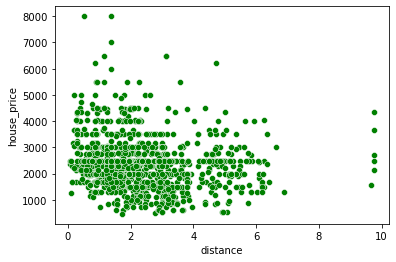

In [18]:
sns.scatterplot(data = df2, x = 'distance', y = 'house_price', color = 'green')

The general trend seems to be that price decreases as distance to the "city square" point increases, this is as expected. However, this could be more clearly displayed with the help of plotnine - a library that allows usage of ggplot in Jupyter/Python. Using geom_point to draw scatter plot and geom_smooth to create the trendline, the following graph is the result.

In [19]:
import plotnine as p9
from matplotlib.pyplot import figure

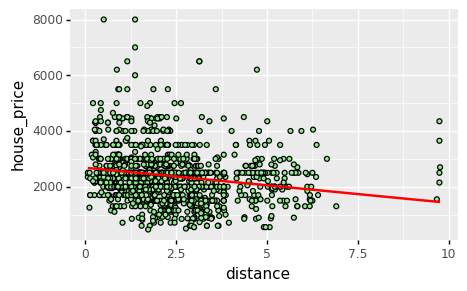

<ggplot: (128053953687)>

In [20]:
(   
p9.ggplot(data = df2) +
p9.aes(x = 'distance', y = 'house_price') +
p9.geom_point(fill = 'lightgreen') +
p9.geom_smooth(se = False, color = 'red') +
p9.theme(figure_size=(5, 3))
)   

The downward trend is now easier to see. 

Overall, this section has looked at the initial scraped dataset, anchored distance to a center point on Blaak for each accommodation, and visualized relationships between the target variable (price) and other features. The price will increase if surface area or number of rooms in accommodation increase, while the opposite will happen if distance increase. The distribution of the accommodations around Rotterdam has also been looked at. Although it is as expected that most places in the dataset concentrate within or around the proximity of the center, there exists other popular neihbourhoods outside this area. This suggests that the trendiness of neighbourhoods based on restaurants and rating/pricing could be anchored and examined in the next step - provisioning. To conclude the EDA of the current dataset, there are relationships that could be investigated and used for modelling; before that, there is also the potential for more data anchoring (besides the distance anchored above).

## 3. Provisioning

Although the initially scraped data has been anchored with the distance to Blaak's point via coordinates, more anchoring could be performed. Having looked at the map in the section above, it can be seen that most of the accommodations in the dataset are distributed into neighbourhoods (or concentrated areas); this gives the inspiration to investigate the trendiness of a neighbourhood based on the rating and expense level of services provided there. 

After researching for a suitable dataset online, none is found in a ready-to-use state. However, this could be overcame with the help of Yelp - a website that records restaurants and services and provide ratings as well as reviews. Thanks to the API in the developer's section of Yelp, data for catering/hotel services can be requested. The first step is to import the necessary libraries.

In [21]:
import requests
import json

After requesting for an API key from [Yelp](https://www.yelp.com/fusion), it is now possible to collect the needed data. The first three lines on code below are the key (hidden), header, and url needed as specified in the Yelp Fusion API documentation. It is necessary to define the lists that will later become the columns of this dataframe. The data to be extracted includes rating, zipcode, price, name, and coordinates of the restaurants in Rotterdam. 

After the creation of the empty lists, there needs to be a while loop that goes through 1998 records of restaurant/hotel services in Rotterdam. This number is based on the reported number of restaurants in the city by [Statista](https://www.statista.com/statistics/829253/number-of-hotels-restaurants-and-cafes-in-the-netherlands-by-city/). The approach in the code below is to continuosly scrape 1 data observation at a time, until 1998 records have been selected. Hence, the limit and offset parameter has both been set to 1. Since limit means the number of observations to select, and has a max value of 50 (set by Yelp), offset is needed to get past the limit. However, if the limit is 50 and offset is x number, the returned result will be the closest 49 observations and x new one. Furthermore, if setting of limit and offset results in more than 1000 data requests at a time, an error will be thrown. Hence, using offset and limit equal 1 ensures all needed observations are scraped without duplicates.

One more issue to take into account is that some services may not have all the data needed (i.e. some may be missing addresses), these are usually not displayed on the Yelp user interface. To avoide taking them, try-except clause can be used to pass by records with missing data.

In [23]:
# credentials
api_key='hidden API key'
headers = {'Authorization': 'Bearer %s' % api_key}
url='https://api.yelp.com/v3/businesses/search'

# empty lists of features
rating = []
zipcode = []
price = []
name = []
longitude = []
latitude = []

# initiating offset for incrementation
offset = 0  

# while loop to increment 1998 times
while offset <= 1998:
    # select search parameters to be sent to Yelp API
    params={'term':'Restaurants', 'location': 'Rotterdam, Zuid-Holland', 'limit': 1, 'offset': offset}
    # Making a get request to the API
    req=requests.get(url, params=params, headers=headers)
    parsed = json.loads(req.text)
    # appending necessary observations and pass by those with missing data
    try:
        businesses = parsed["businesses"]
        price.append(businesses[0]["price"])
        rating.append( businesses[0]["rating"])
        zipcode.append(businesses[0]["location"]["zip_code"])
        name.append(businesses[0]["name"])
        latitude.append(businesses[0]['coordinates']['latitude'])
        longitude.append(businesses[0]['coordinates']['longitude'])
    except:
        pass
    offset+=1

In [49]:
# concatenating lists into a dataframe - yelp
yelp = pd.DataFrame(list(zip(name,zipcode,price,rating, latitude, longitude)), columns = ['name','zipcode','price','rating','latitude', 'longitude'])
yelp.head()

,name,zipcode,price,rating,latitude,longitude
0,Restaurant Bazar,3012 BP,€€,4.0,51.915970,4.479030
1,Boguette,3011 HJ,€,4.5,51.921847,4.488284
2,Mangiare,3012 GX,€€,4.5,51.918696,4.472943
3,Takumi,3014 AJ,€€,4.5,51.920820,4.470150
4,Warung Mini,3012 BM,€,4.5,51.915777,4.477239


In [50]:
yelp.shape

(570, 6)

As a result, the dataframe Yelp with 570 rows and 6 columns have been created (other services may have been unregistered or not completely registered on Yelp API). Besides the yelp rating, latitude, longitude, zipcode, and name, there is also the price column. It is a representation in euros sign with 1 sign meaning cheap, 2 meaning moderate, 3 being expensive, 4 is very expensive. The plot below will visualize the size of each group in the Yelp dataframe.

Text(0.5, 1.0, 'Number of service facilities per price group')

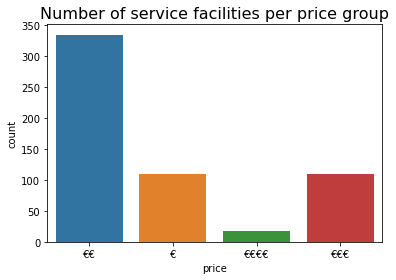

In [26]:
fig, ax = plt.subplots()
sns.countplot(data = yelp, x = 'price')
ax.set_title('Number of service facilities per price group', size = 16)

As expected, most of the recorded services is in the moderate pricing category, with approximately the same number of cheap and expensive places, and a few very expensive locations. A heat map will also be drawn to visualize the distribution of the collected facilities.

In [48]:
# making a map centered around the chosen point on Blaak.
yelp_map = folium.Map(location=[51.9187468, 4.4852446], zoom_start = 13)

# adding heatmap for distribution of services (using coordinates)
heat_data = [[row['latitude'],row['longitude'] ] for index, row in yelp.iterrows()]
plugins.HeatMap(heat_data, radius = 10).add_to(yelp_map)

# mark the 'city square' point, showing where "centrum" is
folium.Marker([51.9187468, 4.4852446], icon=folium.Icon(color='red')).add_to(yelp_map)

yelp_map

It is observable that most restaurants, cafes, bars, and hotels are centered around the city center, within a close proximity of the Blaak's point. There are also other facilities spreaded across the city, however the concetration is not as high. Unlike the accommodation distribution, there is no exception for Pleinweg. More specifically, the services in this area are not concentrated into one area, but rather multiple smaller areas. Moving throughout the map, it can be observed that most spots are inline with the concentration of housing shown in the previous map. This endorses the likelihood of restaurants and other facilities having a role in deciding the price of accommodations in the dataset.

The next step is to anchor the data from Yelp. The method is to first get the neighbourhood of services (first four digits of postcode) and calculate the average rating and pricing (using length of string for price as one extra character means one level up in expensiveness), as well as the number of services in the area. These will then become dictionaries and be mapped onto the area code for accommodations.

In [64]:
# getting first 4 digit of zipcode (area code)
yelp['zip'] = yelp['zipcode'].str.replace('\s','')
yelp['zip']= yelp.zip.str[0:4]

# getting length of price string (expensiveness level)
yelp['price_len'] = yelp.price.str.len()

# get means and number of services by zipcode area
yelp_prices = yelp.groupby(['zip']).price_len.mean()
yelp_rate = yelp.groupby(['zip']).rating.mean()
yelp_servnum = yelp.groupby(['zip']).name.count()

# create three dictionaries for yelp price, rating, and number of services 
yelp_prices = pd.DataFrame(data=yelp_prices)
yelp_rate = pd.DataFrame(data=yelp_rate)
yelp_servnum = pd.DataFrame(data=yelp_servnum)

dict_price = yelp_prices.to_dict()['price_len']
dict_rating = yelp_rate.to_dict()['rating']
dict_servnum = yelp_servnum.to_dict()['name']

# getting area code for df2 and make copy as safe point
df2['zip'] = df2.postcode.str.replace("\D","") 
df3 = df2.copy()

# map the average yelp price, rating, and number of services by area into accommodation dataframe
df3['yelp_prices'] = df3['zip'].map(dict_price)
df3['yelp_ratings'] = df3['zip'].map(dict_rating) 
df3['num_service'] = df3['zip'].map(dict_servnum) 

After mapping, null values will be checked for.

In [65]:
df3.isna().sum()

house_price       0
rental_agency     0
postcode          0
rooms             0
surface           0
type              0
label             0
location          0
distance          0
point             0
latitude          0
longitude         0
altitude          0
zip               0
yelp_prices      63
yelp_ratings     63
num_service      63
dtype: int64

There are null values in the yelp price, rating, and number of services columns. This is because no services in the Yelp dataset are present in those specific areas of Rotterdam. Hence, the rating, price, and number of services of yelp can be set to 0 instead of removing data. Furthermore, the 'point', 'longitude', 'latitude', 'altitude', 'location' can be dropped as they only serve the purpose of anchoring the distance column and plotting. 

In [66]:
df3 = df3.fillna(0)
df3 = df3.drop(columns = ['point', 'longitude', 'latitude', 'altitude', 'location'])

In [67]:
df3.head()

,house_price,rental_agency,postcode,rooms,surface,type,label,distance,zip,yelp_prices,yelp_ratings,num_service
0,3150,Dop & Dop Consultancy,3072ES,5,145,House,Maashavenkade,2.269337,3072,2.058824,3.985294,34.0
1,2500,Fransen Vastgoed,3033AB,2,65,Apartment,Walenburgerweg,1.698153,3033,1.800000,3.800000,5.0
2,2300,Loftly,3014GJ,2,55,Apartment,Nieuwe Binnenweg,1.341806,3014,1.923077,3.807692,39.0
3,2300,Stad en Land Makelaars,3071NR,4,101,Apartment,Maaskade 159 D,0.900334,3071,2.333333,3.833333,6.0
4,2500,Stad en Land Makelaars,3065PG,3,110,Apartment,Huub van den Brulestraat 103,5.484532,3065,0.000000,0.000000,0.0


Above is the preview of the successfully anchored dataframe. The plots below will visualize the possible relationship between the rental price and the newly anchored features.

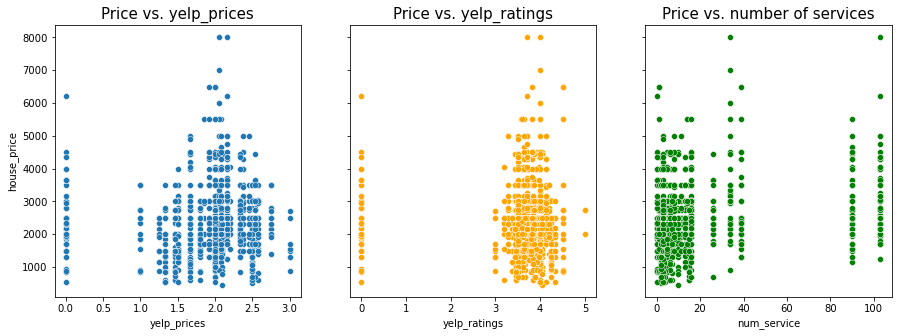

In [70]:
fig, ax = plt.subplots(1,3, sharey = True, figsize = (15, 5))

sns.scatterplot(ax = ax[0], data = df3, x = 'yelp_prices', y = 'house_price')
sns.scatterplot(ax = ax[1], data = df3, x = 'yelp_ratings', y = 'house_price', color = 'orange')
sns.scatterplot(ax = ax[2], data = df3, x = 'num_service', y = 'house_price', color = 'green')

ax[0].set_title('Price vs. yelp_prices', size = 15)
ax[1].set_title('Price vs. yelp_ratings', size = 15)
ax[2].set_title('Price vs. number of services', size = 15)

plt.show()

The majority of the average service price levels range between 1 and 3, while the average ratings are between 3 to 5. As for the number of services within an area, it usually ranges from 0 - 20. There are some places that reach up to 40, or even around 100 facilities. This is likely due to those area being near the center. There does not seem to be a clear linear relationship between rental price and the new features. Whether or not these features may have significant impacts on the target variable is to be seen with feature selection and modelling. The next data to be anchored is the number of supermarkets by area.

To do this, the Yelp API can be re-used with a different 'term' parameter - "grocery". The number of iterations will now be around 2000 as an estimation based on [statista](https://www.statista.com/statistics/701777/number-of-retail-stores-in-rotterdam-by-type/), all steps are similar to what has been done above. It is note worthy that in the statista source, the subject is retail stores. Supermaket (searched with 'grocery' parameter) may have much less result.

In [102]:
# credentials
api_key='fLasUusoQggpY7VAXQW45uvLpgDF4B6HC_BOYvuEYYGQVUaLnqA0ue7OqwsxBXHKks-zZNIfDJnKhLbSvAhsJs4C2As13JwYSIVC1IhipGtDFBhZR4cNGk7-5COIYHYx'
headers = {'Authorization': 'Bearer %s' % api_key}
url='https://api.yelp.com/v3/businesses/search'

# empty lists of features
rating = []
zipcode = []
price = []
name = []
longitude = []
latitude = []

# initiating offset for incrementation
offset = 0  

# while loop to increment 2000 times
while offset <= 2000:
    # select search parameters to be sent to Yelp API
    params={'term':'grocery', 'location': 'Rotterdam, Zuid-Holland', 'limit': 1, 'offset': offset}
    # Making a get request to the API
    req=requests.get(url, params=params, headers=headers)
    parsed = json.loads(req.text)
    # appending necessary observations and pass by those with missing data
    try:
        businesses = parsed["businesses"]
        price.append(businesses[0]["price"])
        rating.append( businesses[0]["rating"])
        zipcode.append(businesses[0]["location"]["zip_code"])
        name.append(businesses[0]["name"])
        latitude.append(businesses[0]['coordinates']['latitude'])
        longitude.append(businesses[0]['coordinates']['longitude'])
    except:
        pass
    offset+=1

In [103]:
# concatenating lists into a dataframe - supermarket
supermarket = pd.DataFrame(list(zip(name,zipcode,price,rating, latitude, longitude)), columns = ['name','zipcode','price','rating','latitude', 'longitude'])
supermarket.head()

,name,zipcode,price,rating,latitude,longitude
0,Gimsel Supermarkt,3011 NB,€€€,4.5,51.924068,4.487810
1,Jumbo,3071 PS,€,4.5,51.910434,4.498014
2,Wah Nam Hong,3014 AP,€€,4.5,51.920652,4.470756
3,SPAR,3012 BP,€€,3.5,51.915750,4.478120
4,Coop,3063 CC,€€,5.0,51.922568,4.500307


In [104]:
supermarket.shape

(65, 6)

It seems that there are actually about 65 supermarkets in Rotterdam that meet the scraping requirement (has a name, postcode, rating and price level, and location registered). Now that the dataframe has been gathered, the distribution by price would be interesting to see. 

Text(0.5, 1.0, 'Number of supermarkets per price group')

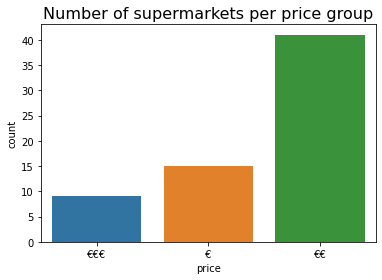

In [105]:
fig, ax = plt.subplots()
sns.countplot(data = supermarket, x = 'price')
ax.set_title('Number of supermarkets per price group', size = 16)

There is no supermaket for the "very expensive" category. Most stores are within the moderate range (similar to Albert Heijn or Jumbo), some are cheap, and only a few are expensive. To further understand the distribution of stores, a folium heatmap will be used.

In [106]:
# making a map centered around the chosen point on Blaak.
sm_map = folium.Map(location=[51.9187468, 4.4852446], zoom_start = 13)

# adding heatmap for distribution of supermarkets (using coordinates)
heat_data = [[row['latitude'],row['longitude'] ] for index, row in supermarket.iterrows()]
plugins.HeatMap(heat_data, radius = 10).add_to(sm_map)

# mark the 'city square' point, showing where "centrum" is
folium.Marker([51.9187468, 4.4852446], icon=folium.Icon(color='red')).add_to(sm_map)

sm_map

Supermarkets are fairly distributed in the center and the surrounding area. It can also be seen that there is some inlining with accommodation and restaurant/bar/cafe areas. The final step is to map average price, rating, and number of supermarkets by area to the accommodation dataframe (now called df4). The steps are similar to mapping services (restaurants/bar/cafe/hotel) above.

In [107]:
# getting first 4 digit of zipcode (area code)
supermarket['zip'] = supermarket['zipcode'].str.replace('\s','')
supermarket['zip']= supermarket.zip.str[0:4]

# getting length of price string (expensiveness level)
supermarket['price_len'] = supermarket.price.str.len()

# get means and number of services by zipcode area
supermarket_prices = supermarket.groupby(['zip']).price_len.mean()
supermarket_rate = supermarket.groupby(['zip']).rating.mean()
supermarket_servnum = supermarket.groupby(['zip']).name.count()

# create three dictionaries for yelp price, rating, and number of stores 
supermarket_prices = pd.DataFrame(data=supermarket_prices)
supermarket_rate = pd.DataFrame(data=supermarket_rate)
supermarket_servnum = pd.DataFrame(data=supermarket_servnum)

dict_price = supermarket_prices.to_dict()['price_len']
dict_rating = supermarket_rate.to_dict()['rating']
dict_servnum = supermarket_servnum.to_dict()['name']

df4 = df3.copy()

# map the average yelp price, rating, and number of stores by area into accommodation dataframe
df4['sp_prices'] = df4['zip'].map(dict_price)
df4['sp_ratings'] = df4['zip'].map(dict_rating) 
df4['sp_num'] = df4['zip'].map(dict_servnum) 

In [108]:
df4.head()

,house_price,rental_agency,postcode,rooms,surface,type,label,distance,zip,yelp_prices,yelp_ratings,num_service,sp_prices,sp_ratings,sp_num
0,3150,Dop & Dop Consultancy,3072ES,5,145,House,Maashavenkade,2.269337,3072,2.058824,3.985294,34.0,2.000000,3.666667,3.0
1,2500,Fransen Vastgoed,3033AB,2,65,Apartment,Walenburgerweg,1.698153,3033,1.800000,3.800000,5.0,3.000000,4.000000,1.0
2,2300,Loftly,3014GJ,2,55,Apartment,Nieuwe Binnenweg,1.341806,3014,1.923077,3.807692,39.0,1.666667,3.666667,9.0
3,2300,Stad en Land Makelaars,3071NR,4,101,Apartment,Maaskade 159 D,0.900334,3071,2.333333,3.833333,6.0,1.500000,4.250000,2.0
4,2500,Stad en Land Makelaars,3065PG,3,110,Apartment,Huub van den Brulestraat 103,5.484532,3065,0.000000,0.000000,0.0,NaN,NaN,NaN


Now that the data has been anchored, null values can be seen by just looking at the first few rows. This means that the area does not have any supermarket within it. Hence, they should be changed to 0.

In [109]:
df4 = df4.fillna(0)
df4.head()

,house_price,rental_agency,postcode,rooms,surface,type,label,distance,zip,yelp_prices,yelp_ratings,num_service,sp_prices,sp_ratings,sp_num
0,3150,Dop & Dop Consultancy,3072ES,5,145,House,Maashavenkade,2.269337,3072,2.058824,3.985294,34.0,2.000000,3.666667,3.0
1,2500,Fransen Vastgoed,3033AB,2,65,Apartment,Walenburgerweg,1.698153,3033,1.800000,3.800000,5.0,3.000000,4.000000,1.0
2,2300,Loftly,3014GJ,2,55,Apartment,Nieuwe Binnenweg,1.341806,3014,1.923077,3.807692,39.0,1.666667,3.666667,9.0
3,2300,Stad en Land Makelaars,3071NR,4,101,Apartment,Maaskade 159 D,0.900334,3071,2.333333,3.833333,6.0,1.500000,4.250000,2.0
4,2500,Stad en Land Makelaars,3065PG,3,110,Apartment,Huub van den Brulestraat 103,5.484532,3065,0.000000,0.000000,0.0,0.000000,0.000000,0.0


Finally, scatterplots will be used to check the distribution between house price and the new features.

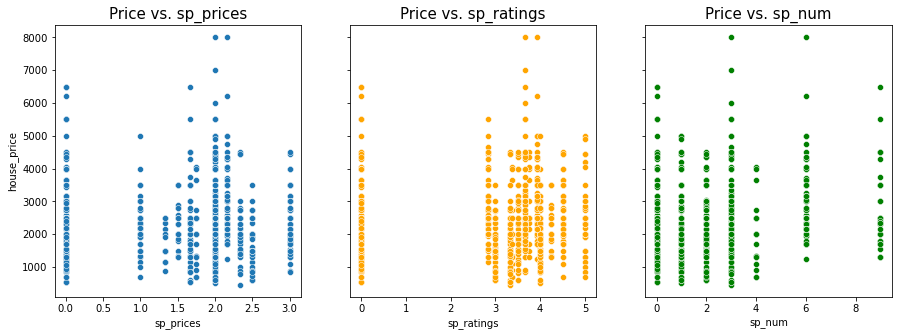

In [110]:
fig, ax = plt.subplots(1,3, sharey = True, figsize = (15, 5))

sns.scatterplot(ax = ax[0], data = df4, x = 'sp_prices', y = 'house_price')
sns.scatterplot(ax = ax[1], data = df4, x = 'sp_ratings', y = 'house_price', color = 'orange')
sns.scatterplot(ax = ax[2], data = df4, x = 'sp_num', y = 'house_price', color = 'green')

ax[0].set_title('Price vs. sp_prices', size = 15)
ax[1].set_title('Price vs. sp_ratings', size = 15)
ax[2].set_title('Price vs. sp_num', size = 15)

plt.show()

The correlation between the new features and target variable are not significantly visible. Further mapping for feature selection in the Modelling notebook will look more into the potential contribution of these features to the prediction.

Now that the data related to supermarkets and services by areas in Rotterdam have also been anchored to the accommodation data, it is necessary to extract the csv to the local system and move onto modelling in the Modelling notebook.

In [111]:
df4.to_csv('data.csv')